In [1]:
import pandas as pd
import os
import csv
import ast
import numpy as np

In [2]:
file_names = os.listdir('GadgetX-NewMDCLUSTER-1/combined-csv/subset/')

In [3]:
dataframes = []
for file_name in file_names:
    df = pd.read_csv(f'GadgetX-NewMDCLUSTER-1/combined-csv/subset/{file_name}')
    dataframes.append(df)

In [4]:
all_data = pd.concat(dataframes)

# Convert the 'ProgenitorsID' column from string to list
all_data['ProgenitorsID'] = all_data['ProgenitorsID'].apply(ast.literal_eval)

# Sort the snapshots in descending order
all_data = all_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

In [5]:
snapshots = sorted(all_data['snapshot'].unique(), reverse=True)

In [6]:
# Create the pairs of halos
pairs = []

for snapshot in snapshots[:-1]:
    halos_n = all_data[all_data['snapshot'] == snapshot]
    halos_n_minus_1 = all_data[all_data['snapshot'] == snapshot - 1]
    id_to_index_n_minus_1 = {row['ID']: i for i, row in halos_n_minus_1.iterrows()}
    for i, halo in halos_n.iterrows():
        progenitors = halo['ProgenitorsID']
        for progenitor in progenitors:
            if progenitor == -1:
                continue
            j = id_to_index_n_minus_1.get(progenitor)
            if j is not None:
                progenitor_halo = halos_n_minus_1.loc[j]
                pair = pd.concat([halo, progenitor_halo.rename(lambda x: f'progenitor_{x}')])

                # calculate relative location and velocity for each dimension
                rel_location = 0
                rel_velocity = 0
                for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
                    rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
                    rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
                # compute the square root to get the Euclidean distance
                pair['rel_location'] = np.sqrt(rel_location)
                pair['rel_velocity'] = np.sqrt(rel_velocity)
                
                pairs.append(pair.to_dict())

pairs = pd.DataFrame(pairs)
pairs['Is_Progenitor'] = 1
print(pairs.head())


   hostHalo  numSubStruct          Mvir  npart             Xc             Yc  \
0         0             0  4.253410e+11    557  495305.716991  512879.908085   
1         0             0  4.253410e+11    557  495305.716991  512879.908085   
2         0             1  2.573640e+11    414  513002.943993  509132.084250   
3         0             0  2.358530e+11    347  503362.696422  482967.633166   
4         0             0  2.536180e+11    340  495374.939839  513156.708082   

              Zc     VXc     VYc     VZc  ...  progenitor_Phi0  \
0  497875.293096   21.36 -153.28   80.43  ...         261893.0   
1  497875.293096   21.36 -153.28   80.43  ...          97460.8   
2  504879.002273 -280.17 -238.04  -95.84  ...         383819.0   
3  509224.192092  -79.15  206.59 -239.60  ...         338967.0   
4  498013.828198   56.51 -320.93  -22.58  ...         194523.0   

   progenitor_cNFW   progenitor_ID  progenitor_numProgenitors  \
0          5.99606  29000000000001                       

In [7]:
pairs.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/progenitor-paris.csv', index=False)

In [8]:
# Define a function to compute the Euclidean distance between two halos
def compute_distance(halo1, halo2):
    return np.sqrt((halo1['Xc'] - halo2['Xc'])**2 + (halo1['Yc'] - halo2['Yc'])**2 + (halo1['Zc'] - halo2['Zc'])**2)

# Determine the number of non-progenitor pairs to create
num_non_progenitor_pairs = len(pairs)

non_progenitor_pairs = []

# Define the maximum distance for non-progenitors
max_distance = 2000

for snapshot in snapshots[:-1]:
    halos_n = all_data[all_data['snapshot'] == snapshot]
    halos_n_minus_1 = all_data[all_data['snapshot'] == snapshot - 1]
    id_to_index_n_minus_1 = {row['ID']: i for i, row in halos_n_minus_1.iterrows()}
    
    for i, halo in halos_n.iterrows():
        progenitors = halo['ProgenitorsID']
        for j, progenitor_halo in halos_n_minus_1.iterrows():
            progenitor_id = progenitor_halo['ID']
            # Check if the halo is not a progenitor and the distance is less than the maximum distance
            if progenitor_id not in progenitors and compute_distance(halo, progenitor_halo) < max_distance:
                pair = pd.concat([halo, progenitor_halo.rename(lambda x: f'progenitor_{x}')])

                # calculate relative location and velocity
                rel_location = 0
                rel_velocity = 0
                for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
                    rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
                    rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
                # compute the square root to get the Euclidean distance
                pair['rel_location'] = np.sqrt(rel_location)
                pair['rel_velocity'] = np.sqrt(rel_velocity)

                non_progenitor_pairs.append(pair.to_dict())
                
                # Stop adding non-progenitor pairs when we reach the desired number
                if len(non_progenitor_pairs) == num_non_progenitor_pairs:
                    break
        # Stop adding non-progenitor pairs when we reach the desired number
        if len(non_progenitor_pairs) == num_non_progenitor_pairs:
            break
    # Stop adding non-progenitor pairs when we reach the desired number
    if len(non_progenitor_pairs) == num_non_progenitor_pairs:
        break

non_progenitor_pairs = pd.DataFrame(non_progenitor_pairs)

# Add the target variable
non_progenitor_pairs['Is_Progenitor'] = 0

non_progenitor_pairs.head()


,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,0,0,4.253410e+11,557,495305.716991,512879.908085,497875.293096,21.36,-153.28,80.43,...,194523.0,3.39571,29000000000005,1,[28000000000005],7.959,29,357.798580,194.930377,0
1,0,0,4.253410e+11,557,495305.716991,512879.908085,497875.293096,21.36,-153.28,80.43,...,107299.0,3.18306,29000000000048,1,[28000000000077],7.959,29,588.083202,279.464515,0
2,0,0,4.253410e+11,557,495305.716991,512879.908085,497875.293096,21.36,-153.28,80.43,...,51298.4,3.82401,29000000000063,1,[28000000000132],7.959,29,1453.402827,234.818511,0
3,0,0,4.253410e+11,557,495305.716991,512879.908085,497875.293096,21.36,-153.28,80.43,...,93592.6,9.25825,29000000000070,1,[28000000000083],7.959,29,663.919985,119.587796,0
4,0,0,4.253410e+11,557,495305.716991,512879.908085,497875.293096,21.36,-153.28,80.43,...,87202.7,3.94936,29000000000079,1,[28000000000146],7.959,29,1682.161689,119.829003,0


In [9]:
non_progenitor_pairs.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/non_progenitor_pairs.csv', index=False)

In [10]:
# Combine progenitor and non-progenitor pairs into a single dataset
training_data = pd.concat([pairs, non_progenitor_pairs])

# Shuffle the data
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)

training_data.head()

,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,0,0,3.367920e+10,42,512241.391035,525452.015492,490468.806945,-188.11,-208.47,0.24,...,95033.1,9.38435,29000000000168,1,[28000000000140],7.959,29,410.807096,132.286765,0
1,0,0,2.441050e+10,29,503465.592861,499040.360962,506668.359041,-152.85,-90.28,-127.40,...,62234.0,7.15111,29000000000670,0,[-1],7.959,29,1147.375907,131.375196,0
2,0,0,2.544330e+10,29,495221.245289,504482.579231,506177.111467,172.32,-179.39,-422.02,...,34460.9,4.46346,29000000000418,1,[28000000000481],7.959,29,1302.611235,359.600781,0
3,0,0,2.266880e+10,26,489577.448950,512436.043925,493462.569103,179.31,-245.17,166.54,...,30374.2,5.45286,26000000000262,0,[-1],8.521,26,30.481471,8.204407,1
4,0,0,4.406850e+10,51,505121.839898,491449.136819,514531.795468,-35.83,-20.28,-403.50,...,74196.2,12.40330,29000000000261,1,[28000000000231],7.959,29,276.857314,180.696914,0


In [11]:
training_data.to_csv('GadgetX-NewMDCLUSTER-1/progenitor-pair/training_data.csv', index=False)

In [12]:
# Define the features to keep
# features = ['numSubStruct', 'Mvir', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 
#             'Rvir', 'Rmax', 'r2', 'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 
#             'Lx', 'Ly', 'Lz', 'b', 'c', 'Eax', 'Eay', 'Eaz', 'Ebx', 'Eby', 'Ebz', 'Ecx', 'Ecy', 'Ecz', 
#             'ovdens','fMhires', 'Ekin', 'Epot', 'SurfP', 'Phi0', 'cNFW',
#             'Is_Progenitor']

features = ['rel_location', 'rel_velocity', 'Is_Progenitor', 'Mvir']

#progenitor_features = [f'progenitor_{feature}' for feature in features if feature != 'Is_Progenitor']
progenitor_features = ['progenitor_Mvir']

# Select only the defined features from the training data
training_data = training_data[features + progenitor_features]

training_data.head()


,rel_location,rel_velocity,Is_Progenitor,Mvir,progenitor_Mvir
0,410.807096,132.286765,0,3.367920e+10,3.494840e+10
1,1147.375907,131.375196,0,2.441050e+10,1.711970e+10
2,1302.611235,359.600781,0,2.544330e+10,2.266880e+10
3,30.481471,8.204407,1,2.266880e+10,2.116340e+10
4,276.857314,180.696914,0,4.406850e+10,2.972320e+10


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = training_data.drop('Is_Progenitor', axis=1)
y = training_data['Is_Progenitor']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import binarize

weights = {0: 1, 1: 20}
# Train the Random Forest model
model = RandomForestClassifier(class_weight=weights, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Change the threshold here
threshold = 0.5
y_pred = binarize(y_pred_prob.reshape(1, -1), threshold=threshold)[0]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       551
           1       1.00      1.00      1.00       587

    accuracy                           1.00      1138
   macro avg       1.00      1.00      1.00      1138
weighted avg       1.00      1.00      1.00      1138



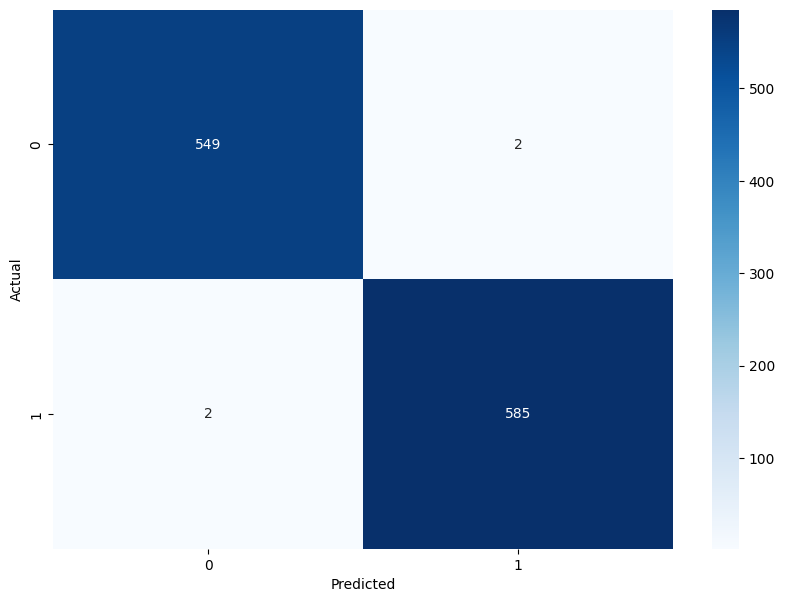

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [16]:
def create_merger_tree(halo, model, scaler, all_data, threshold=0.5):
    
    merger_tree = [halo]
    
    features = ['rel_location', 'rel_velocity', 'Mvir']
    progenitor_features = ['progenitor_Mvir']

    # Get halos in previous snapshot
    previous_snapshot = halo['snapshot'] - 1
    previous_halos = all_data[all_data['snapshot'] == previous_snapshot]
    
    # For each halo in the previous snapshot, predict whether it will merge with the current halo
    for i, previous_halo in previous_halos.iterrows():
        # Create the feature vector for the current pair of halos
        pair = pd.concat([halo, previous_halo.rename(lambda x: f'progenitor_{x}')])

        # calculate relative location and velocity
        rel_location = 0
        rel_velocity = 0
        for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']):
            rel_location += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
        for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']):
            rel_velocity += (pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2
                
        # compute the square root to get the Euclidean distance
        pair['rel_location'] = np.sqrt(rel_location)
        pair['rel_velocity'] = np.sqrt(rel_velocity)

        feature_vector = pair[features + progenitor_features]
        feature_vector_scaled = scaler.transform(feature_vector.values.reshape(1, -1))
        
        # Use the model to predict the probability of the previous halo being a progenitor of the current halo
        pred_prob = model.predict_proba(feature_vector_scaled)[:, 1]
        
        # Apply the threshold to the predicted probabilities to make a final prediction
        prediction = binarize(pred_prob.reshape(1, -1), threshold=threshold)[0]
        
        # If the model predicts a merger, add the previous halo to the merger tree
        if prediction == 1:
            merger_tree.append(previous_halo)
            
            # Recursive call to find the progenitor's progenitor
            merger_tree += create_merger_tree(previous_halo, model, scaler, all_data, threshold)
                
    return merger_tree


In [17]:

import warnings
warnings.filterwarnings('ignore')

halo = all_data[all_data['ID'] == 30000000000007].iloc[-1]
merger_tree = create_merger_tree(halo, model, scaler, all_data)
for halo in merger_tree:
    print(halo['ID'])


30000000000007
29000000000011
29000000000011
28000000000012
28000000000012
27000000000045
27000000000045
26000000000050
26000000000050
25000000000038
25000000000038
24000000000043
24000000000043
23000000000041
23000000000041
22000000000040
22000000000040
21000000000040
21000000000040
20000000000038
20000000000038
19000000000034
19000000000034
28000000000111
28000000000111
27000000000022
27000000000022
26000000000036
26000000000036
25000000000034
25000000000034
24000000000048
24000000000048
23000000000058
23000000000058
29000000000145
29000000000145


In [18]:
import joblib
joblib.dump(model, "GadgetX-NewMDCLUSTER-1/progenitor-pair/random_forest_30_snap.joblib")

['GadgetX-NewMDCLUSTER-1/progenitor-pair/random_forest_30_snap.joblib']

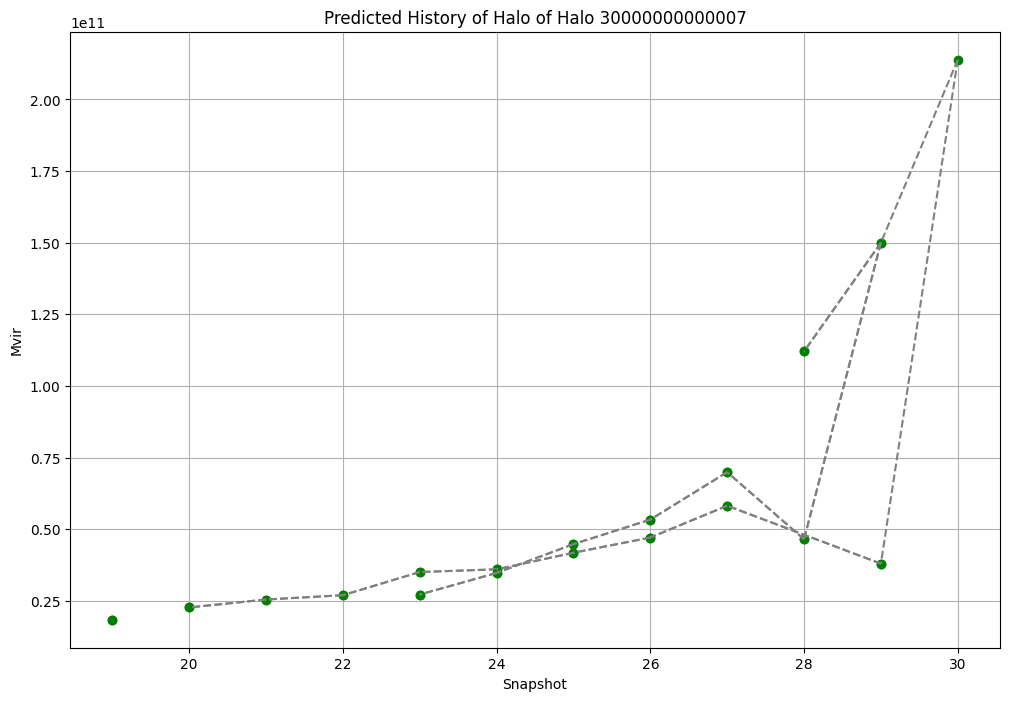

In [30]:
def track_halo_history(halo, model, scaler, all_data):
    
    history = create_merger_tree(halo, model, scaler, all_data)
    return pd.DataFrame(history)

def plot_halo_history(halo_id, halo_history, title):
    plt.figure(figsize=(12, 8))

    id_to_point = {row['ID']: (row['snapshot'], row['Mvir']) for _, row in halo_history.iterrows()}

    for halo_id, group in halo_history.groupby('ID'):
        plt.plot(group['snapshot'], group['Mvir'], 'o-', color='green')

        for _, row in group.iterrows():
            for progenitor in row['ProgenitorsID']:
                if progenitor == -1 or progenitor not in id_to_point:
                    continue
                x_values = [id_to_point[halo_id][0], id_to_point[progenitor][0]]
                y_values = [id_to_point[halo_id][1], id_to_point[progenitor][1]]
                plt.plot(x_values, y_values, '--', color='grey')

    plt.xlabel('Snapshot')
    plt.ylabel('Mvir')
    plt.title(f"{title} of Halo {halo_id}")
    plt.grid(True)
    plt.show()



halo = all_data[all_data['ID'] == 30000000000007].iloc[-1]

# predicte the halo history
predicted_halo_history = track_halo_history(halo, model, scaler, all_data)

# Plot the history
plot_halo_history(halo['ID'], predicted_halo_history, 'Predicted History of Halo')


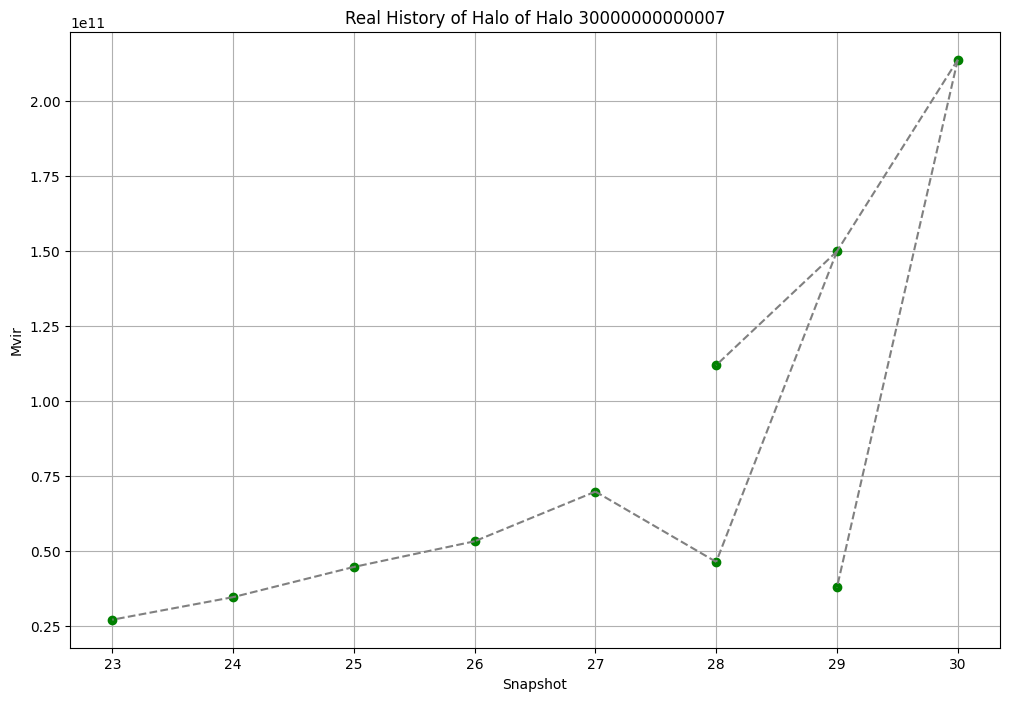

In [42]:
def track_halo_history_real(halo_id, snapshot, df):
    halo = df[(df['ID'] == halo_id) & (df['snapshot'] == snapshot)]
    if len(halo) == 0:
        return pd.DataFrame()
    progenitors = halo.iloc[0]['ProgenitorsID']
    history = halo
    if progenitors:
        for progenitor in progenitors:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_history = track_halo_history_real(progenitor, snapshot - 1, df)
            history = pd.concat([history, progenitor_history])
    return history


halo_id = 30000000000007 

latest_snapshot = all_data['snapshot'].max() # Can change the snapshot number here

real_halo_history = track_halo_history_real(halo_id, latest_snapshot, all_data)

plot_halo_history(halo_id, real_halo_history, 'Real History of Halo')


# Testing on new data

In [47]:
new_file_names = os.listdir('GadgetX-NewMDCLUSTER-2/combined-csv/')

dataframes = []
for new_file_names in new_file_names:
    df = pd.read_csv(f'GadgetX-NewMDCLUSTER-2/combined-csv/{new_file_names}')
    dataframes.append(df)

new_data = pd.concat(dataframes)

new_data['ProgenitorsID'] = new_data['ProgenitorsID'].apply(ast.literal_eval)

new_data = new_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

halo = new_data[new_data['ID'] == 35000000000001].iloc[-1]  # The halo in the last snapshot

merger_tree = create_merger_tree(halo, model, scaler, new_data)

for halo in merger_tree:
    print(halo['ID'])

35000000000001
34000000000001
34000000000001
33000000000001
33000000000001
32000000000001
32000000000001
31000000000001
31000000000001
30000000000001
30000000000001
29000000000001
29000000000001
28000000000001
28000000000001
27000000000001
27000000000001
26000000000001
26000000000001
25000000000002
25000000000002
24000000000003
24000000000003
23000000000003
23000000000003
22000000000007
22000000000007
34000000000592
34000000000592


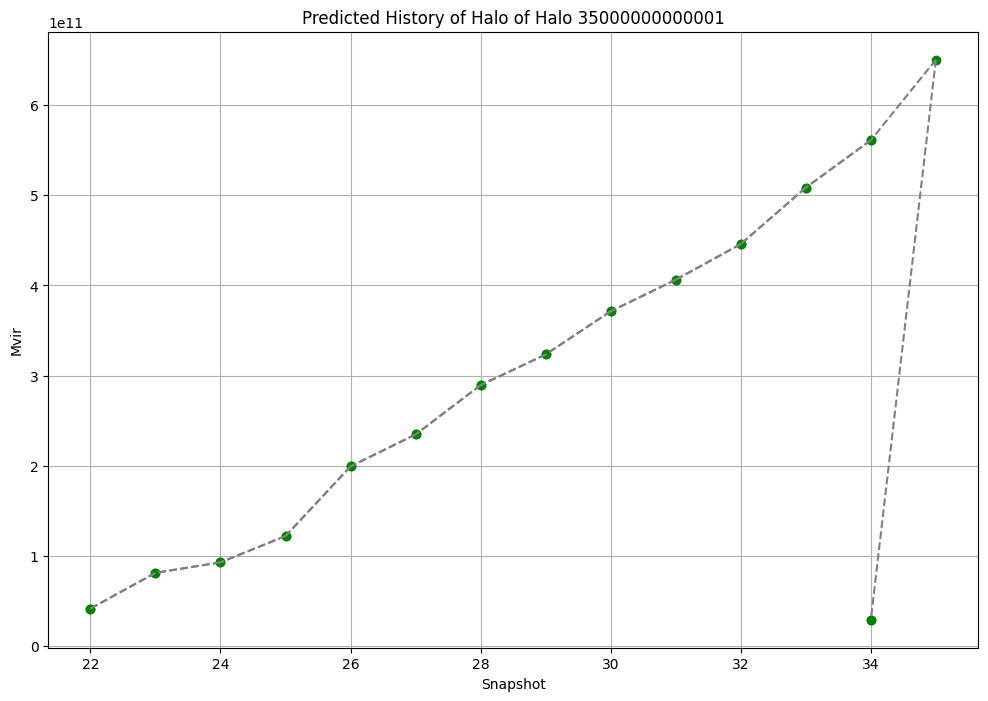

In [48]:
halo = new_data[new_data['ID'] == 35000000000001].iloc[-1] 

predicted_halo_history = track_halo_history(halo, model, scaler, new_data)

plot_halo_history(halo['ID'], predicted_halo_history, 'Predicted History of Halo')

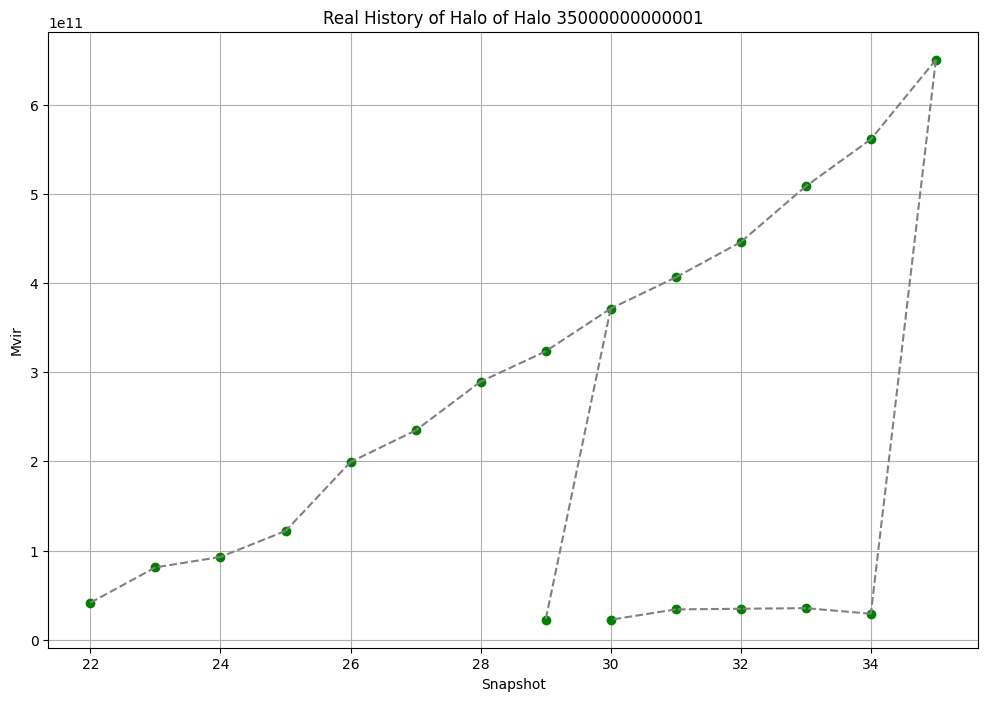

In [59]:
halo_id = 35000000000001

latest_snapshot = 35

real_halo_history = track_halo_history_real(halo_id, latest_snapshot, new_data)

plot_halo_history(halo_id, real_halo_history, 'Real History of Halo')